# 2110433 - Computer Vision (2023/2)
## Lab 3 - Edge Processing
In this lab, we will learn to utilize edge information to extract useful "things" from images. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer

Import OpenCV, Numpy and Matplotlib as always

In [1]:
import cv2
import math
import numpy as np
import random as rng
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import urllib.request
%matplotlib inline

Use <a href="https://docs.opencv.org/3.4.1/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56">imread</a> function to read image from file. Since edge detection functions <b>require</b> a single channel input image, we must convert the input image into grayscale by using <a href="https://docs.opencv.org/3.4.1/d7/d1b/group__imgproc__misc.html#ga397ae87e1288a81d2363b61574eb8cab">cvtColor</a>.

inputImage dimensions (323, 300, 3)


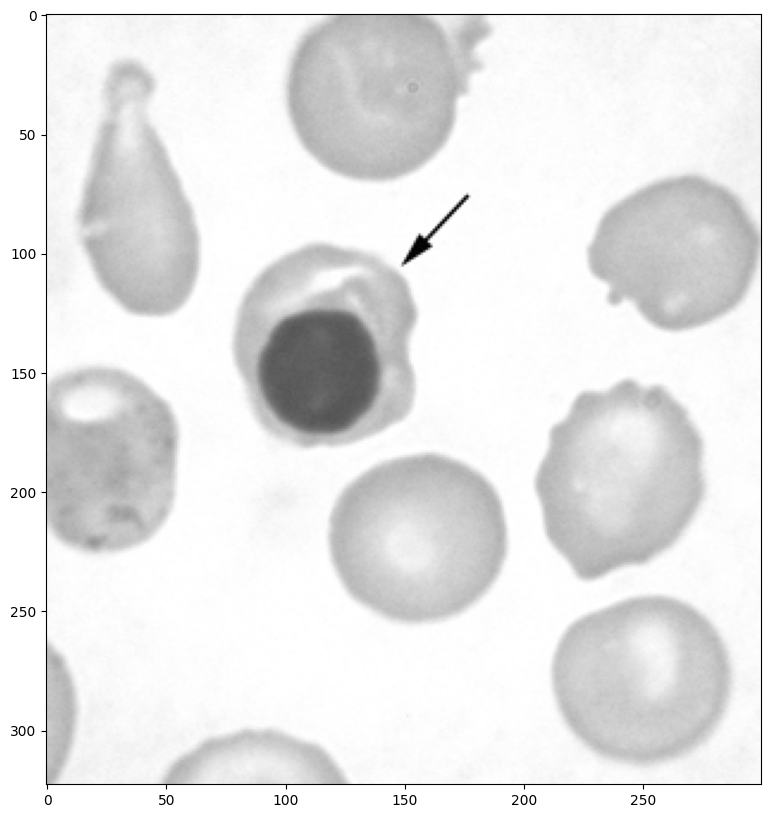

In [2]:
inputImage = cv2.imread("assets/Lab3-rbc.jpg")
print('inputImage dimensions', inputImage.shape)
inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(inputImageGray,cmap = 'gray')
plt.show()

## Edge Detection

Edge detection is one of the fundamental operations in image processing and computer vision, including object detectors and image segmentation algorithms. It helps us reduce the amount of data  to process while still maintains the structural/shape representation of the image. OpenCV already implemented some famous edge detector. In this section, we will apply well-known edge detector on the provided image.

### 1.Sobel Edge Detector
Sobel edge detector is a gradient based method based on the first order derivatives. It separately calculates the first derivatives for the X and Y axes. You can use it by calling <a href="https://docs.opencv.org/3.4.2/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d">cv2.Sobel</a>

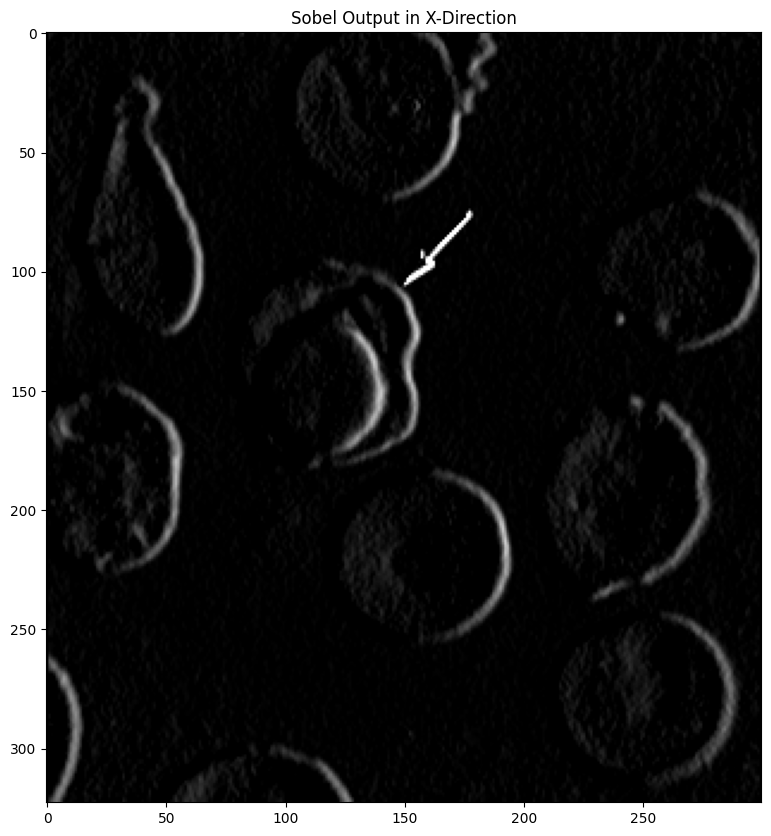

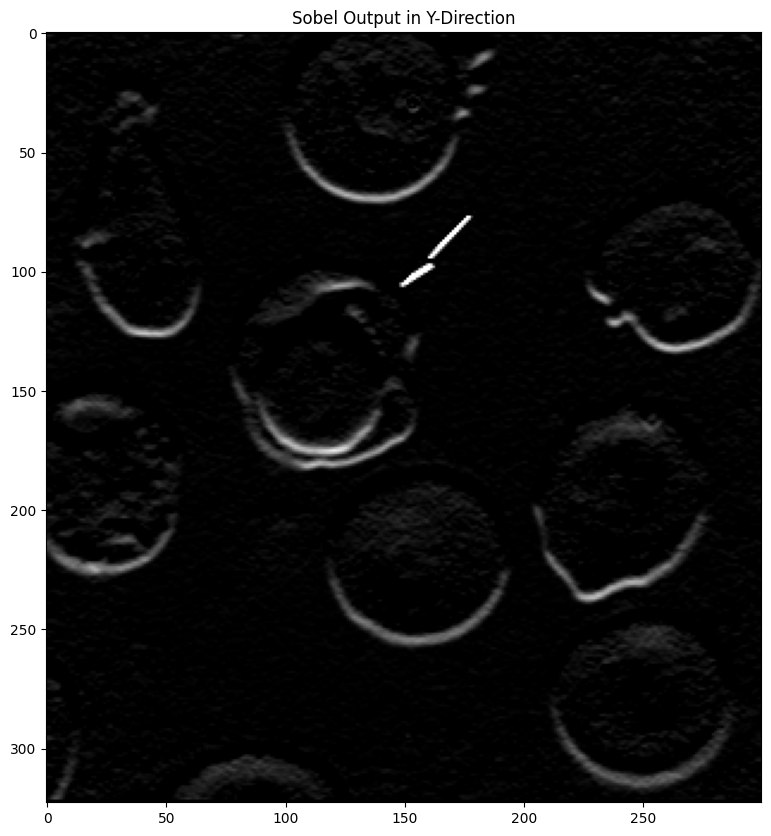

In [3]:
sobelXOutput = cv2.Sobel(inputImageGray,cv2.CV_8U,1,0,ksize=3)
sobelYOutput = cv2.Sobel(inputImageGray,cv2.CV_8U,0,1,ksize=3)
plt.figure(figsize=(10,10))
plt.title('Sobel Output in X-Direction')
plt.imshow(sobelXOutput, cmap='gray')
plt.figure(figsize=(10,10))
plt.title('Sobel Output in Y-Direction')
plt.imshow(sobelYOutput, cmap='gray')
plt.show()

#### <b>Remark</b>
There is a slight problem with both outputs because of their data type. Since black-to-white transition is taken as positive slope (positive value) while white-to-black is taken as a negative slope (negative value), uint8 data type is only capable for positive value. When you convert data to np.uint8, all negative slopes are considered as zero and some edges will be missed. To overcome this problem we will apply absolute operator before convert into np.uint8

float64


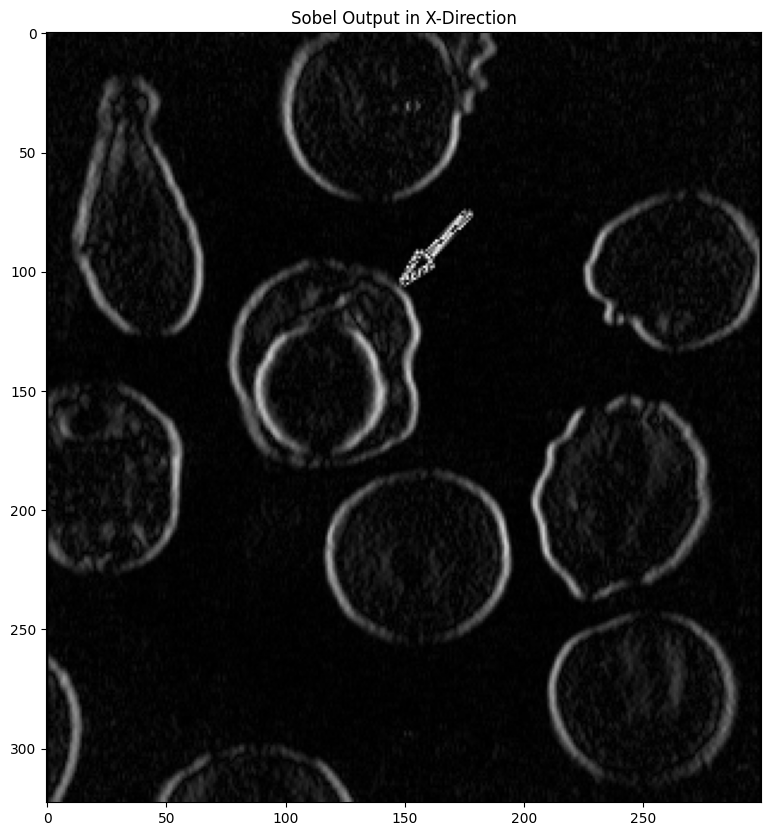

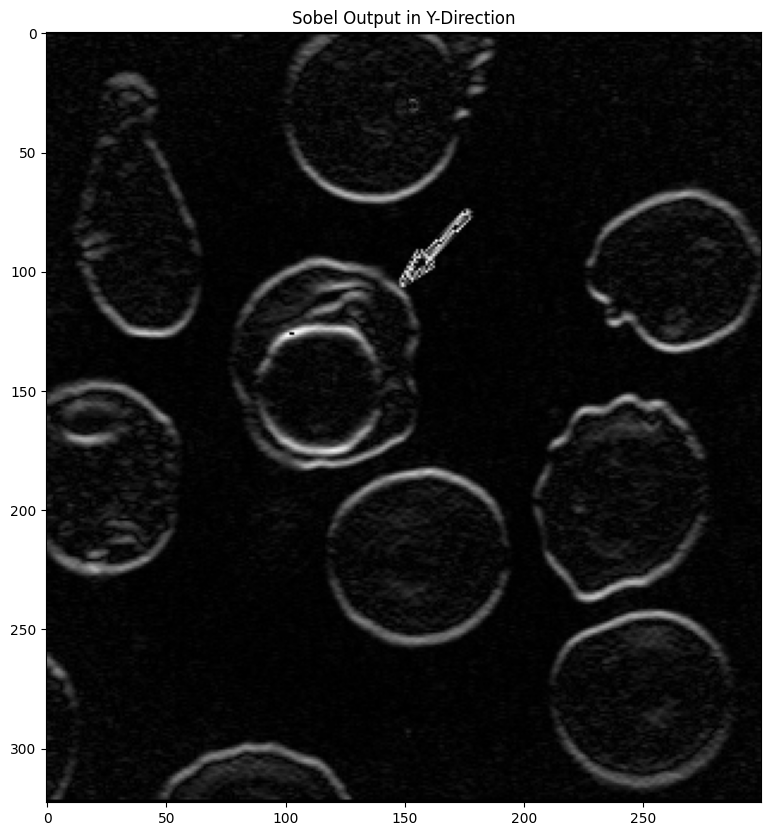

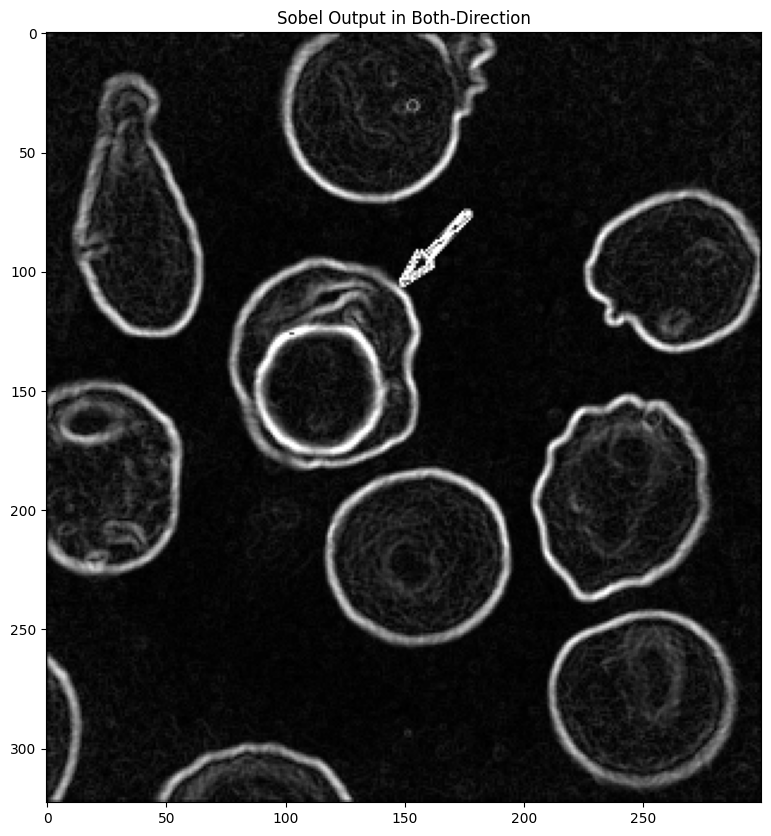

In [4]:
sobelXOutput_64F = cv2.Sobel(inputImageGray,cv2.CV_64F,1,0,ksize=3)
print(sobelXOutput_64F.dtype)
sobelXOutput_64F = np.uint8(np.absolute(sobelXOutput_64F))
sobelYOutput_64F = cv2.Sobel(inputImageGray,cv2.CV_64F,0,1,ksize=3)
sobelYOutput_64F = np.uint8(np.absolute(sobelYOutput_64F))
plt.figure(figsize=(10,10))
plt.title('Sobel Output in X-Direction')
plt.imshow(sobelXOutput_64F, cmap='gray')
plt.figure(figsize=(10,10))
plt.title('Sobel Output in Y-Direction')
plt.imshow(sobelYOutput_64F, cmap='gray')
plt.show()
plt.figure(figsize=(10,10))
plt.title('Sobel Output in Both-Direction')
plt.imshow(np.minimum(255,sobelXOutput_64F.astype(np.float64) + sobelYOutput_64F.astype(np.float64)).astype(np.uint8), cmap='gray')
plt.show()


### 2.Robert Edge Detector
Use the knowledge from lecture section 🤔 and <b>your own</b> myFilter2D function from Lab 2 - Assignment3 to built Robert edge detector! Compare the result with original OpenCV <a href="https://docs.opencv.org/3.4.2/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04">cv2.filter2D</a>.

In [5]:
#### Your filter2D function! ####
def applyFilter(im, k):
    k = np.array(k, dtype=np.double)
    out = np.zeros((im.shape[0]-k.shape[0]+1, im.shape[1]-k.shape[1]+1), dtype=np.int32)
    for i in range(im.shape[0]-k.shape[0]+1):
        for j in range(im.shape[1]-k.shape[1]+1):
            out[i][j] = np.sum(im[i:i+k.shape[0], j:j+k.shape[1]]*k)
    return np.uint8(np.minimum(255, np.absolute(out)))
def myFilter2D(inputImage, kernel, paddingMethod="constant", paddingValue=0):
    if kernel.shape[0]%2 == 0 or kernel.shape[1]%2 == 0:
        print("Kernel size must be odd") 
    elif paddingMethod == "constant":
        outputImage = np.pad(inputImage, ((kernel.shape[0]//2,),(kernel.shape[1]//2,)), paddingMethod, constant_values=paddingValue)
    elif paddingMethod == "replicate":
        outputImage = np.pad(inputImage, ((kernel.shape[0]//2,),(kernel.shape[1]//2,)), "symmetric")
    elif paddingMethod == "valid":
        outputImage = inputImage[kernel.shape[0]//2:inputImage.shape[0]-kernel.shape[0]//2, kernel.shape[1]//2:inputImage.shape[1]-kernel.shape[1]//2]
    else:
        print("Undefined padding method")
    return applyFilter(outputImage, kernel)

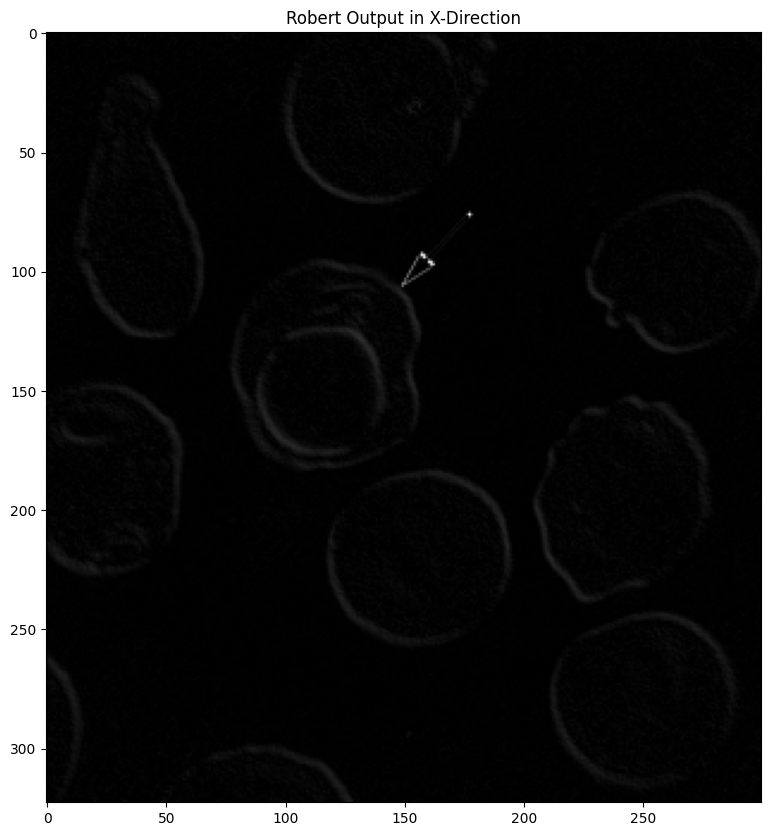

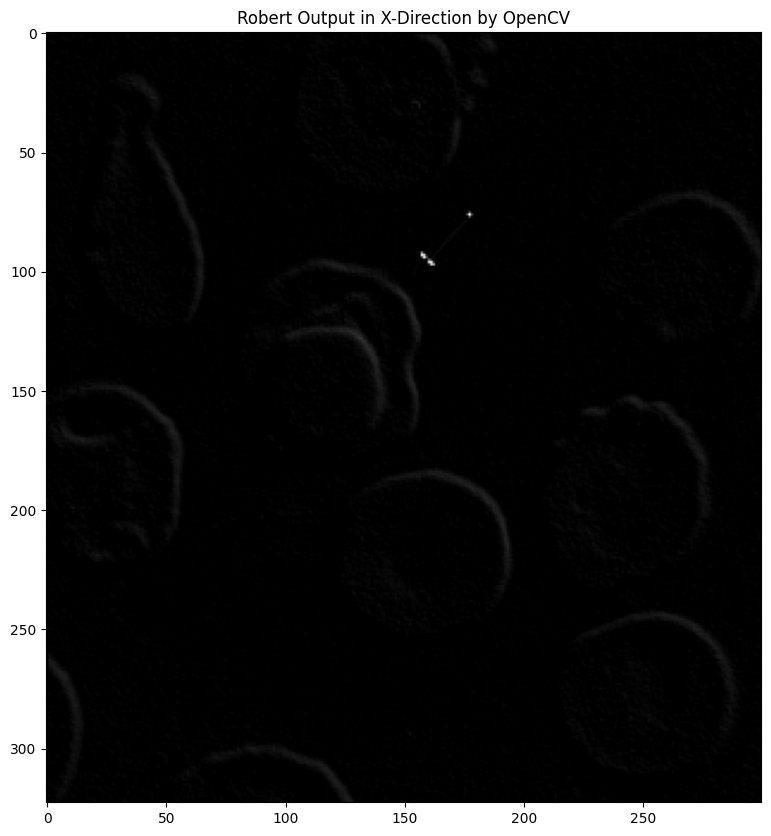

In [6]:
#### FILL HERE ####
RobertX = np.array([[0,1,0],[-1,0,0],[0,0,0]])
RobertX2 = np.array([[0,1],[-1,0]])
RobertY = np.array([[1,0,0],[0,-1,0],[0,0,0]])

outRobertX = myFilter2D(inputImageGray, RobertX, "replicate")
plt.figure(figsize=(10,10))
plt.title('Robert Output in X-Direction')
plt.imshow(outRobertX, cmap='gray')

plt.figure(figsize=(10,10))
plt.title('Robert Output in X-Direction by OpenCV')
plt.imshow(cv2.filter2D(np.minimum(255, np.absolute(inputImageGray)), -1, RobertX2), cmap='gray')
####

### 3. Laplacian
Laplacian filter is an edge detector used to compute the second derivatives of an image

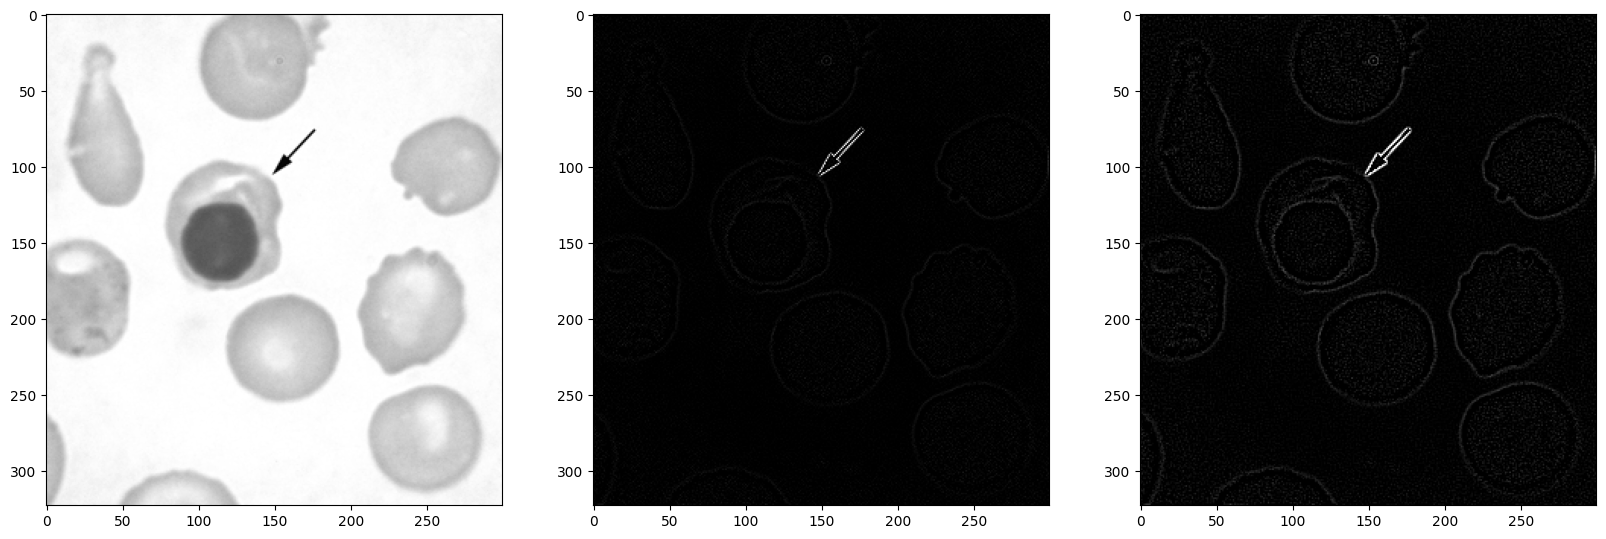

In [7]:
laplacianKernel_1 = np.array([[0,-1,0], 
                              [-1,4,-1], 
                              [0,-1,0]])
laplacianKernel_2 = np.array([[-1,-1,-1], 
                              [-1,8,-1], 
                              [-1,-1,-1]])

inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
laplacianOutput_1 = cv2.filter2D(inputImageGray, -1, laplacianKernel_1)
laplacianOutput_2 = cv2.filter2D(inputImageGray, -1, laplacianKernel_2)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(inputImageGray, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(laplacianOutput_1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(laplacianOutput_2, cmap='gray')
plt.show()

#### a. Image Sharpening

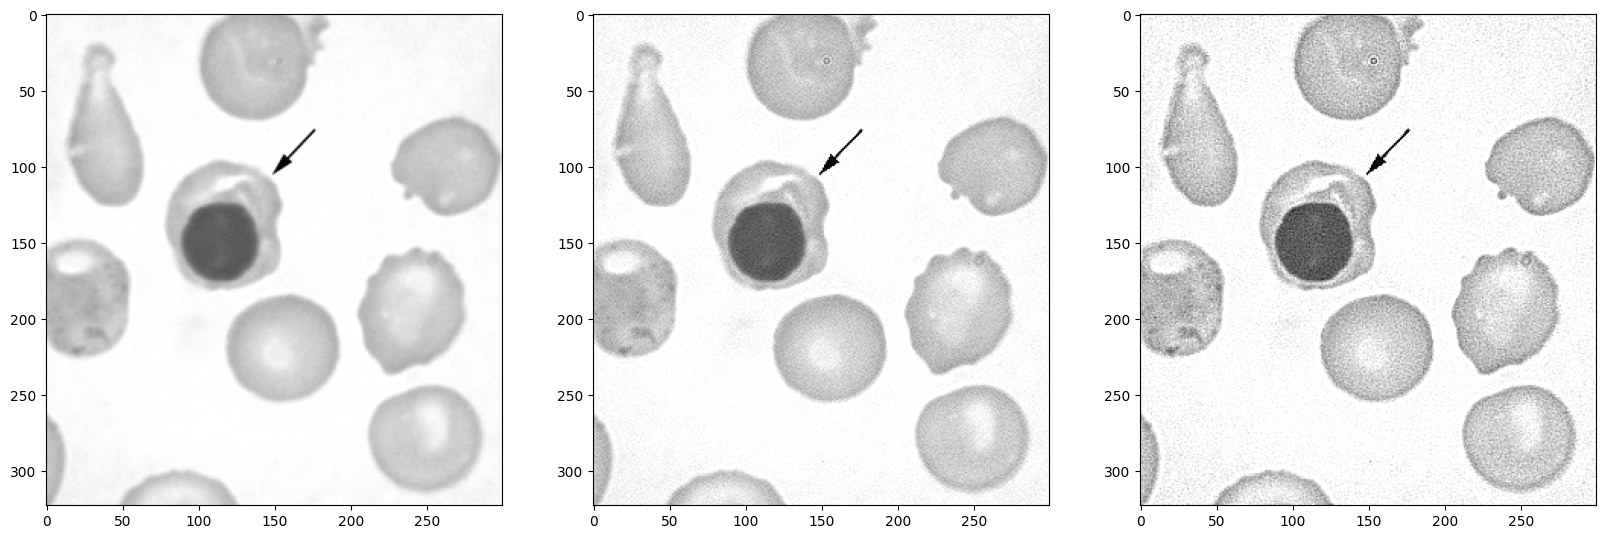

In [8]:
sharpenKernel_1 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
sharpenKernel_2 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
sharpenOutput_1 = cv2.filter2D(inputImageGray, -1, sharpenKernel_1)
sharpenOutput_2 = cv2.filter2D(inputImageGray, -1, sharpenKernel_2)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(inputImageGray, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(sharpenOutput_1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(sharpenOutput_2, cmap='gray')
plt.show()

### 4.Canny Edge Detector
Canny edge detector is a popular edge detection algorithm. It is a multi-stages algorithm based on Sobel edge detector and is considered to give a better result. You can read <a href="https://docs.opencv.org/3.4.2/da/d22/tutorial_py_canny.html">here</a> for short summary of this algorithm. You can Canny edge detector by calling <a href="https://docs.opencv.org/3.4.2/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de">cv2.Canny</a>


In [9]:
# Use ipywidgets and interact function to see the result of Canny edge detctor by yourself.
#### FILL HERE ####
def myCanny1(mi, ma):
    outCannyL2 = cv2.Canny(inputImageGray, mi, ma, L2gradient=True)
    outCannyL1 = cv2.Canny(inputImageGray, mi, ma, L2gradient=False)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(outCannyL2, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(outCannyL1, cmap='gray')
interact(myCanny1, mi=widgets.IntSlider(min=-100,max=400,step=2,value=1),ma=widgets.IntSlider(min=1,max=400,step=2,value=1));
####

interactive(children=(IntSlider(value=1, description='mi', max=400, min=-100, step=2), IntSlider(value=1, desc…

### 5. Structured Edge Detector
[Bonus] The gradient based edge detectors are typically susceptible to noise in the image and it is difficult to overcome this problem by using traditional pixel features. Instead of finding suitable rule-based methods for each task, a learning based edge detector named "Structured Edge" was proposed by Microsoft researcher team in International Conference on Computer Vision 2013 (ICCV2013). This algorithm use random forest to give each pixel edge intensity value based on locality feature. You can read their paper <a href="https://www.microsoft.com/en-us/research/wp-content/uploads/2013/12/DollarICCV13edges.pdf">here</a>.

In [10]:
# Grab edge model file from opencv_contrib repository
urllib.request.urlretrieve('https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/cv/ximgproc/model.yml.gz', 'assets/structuredEdgeModel.yml.gz')

('assets/structuredEdgeModel.yml.gz',
 <http.client.HTTPMessage at 0x22d705fb9d0>)

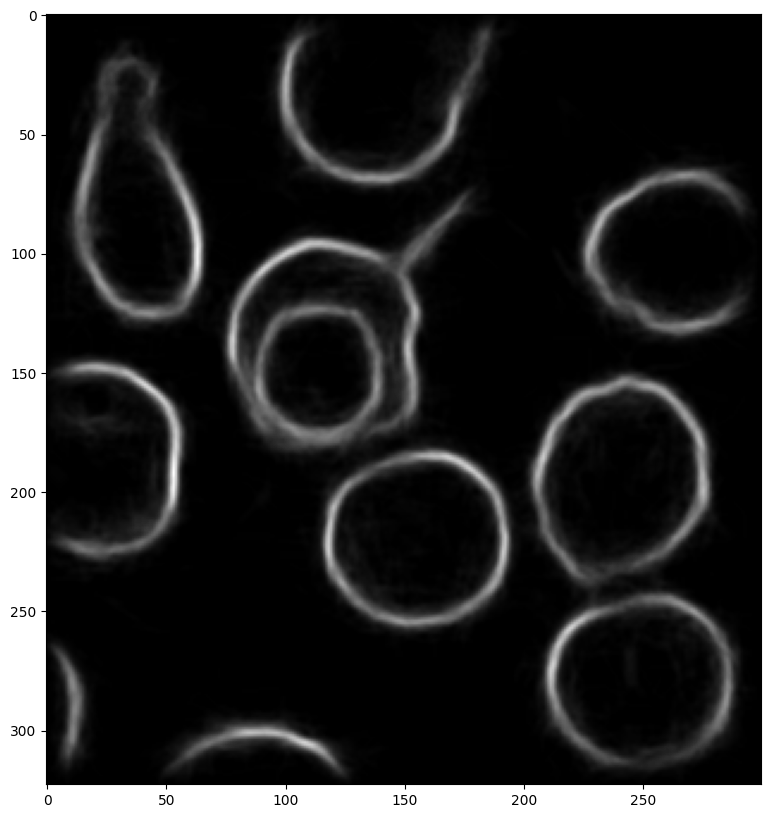

In [11]:
# Structured Edge Detector requires input to be in RGB order
structuredEdgeDetector = cv2.ximgproc.createStructuredEdgeDetection('assets/structuredEdgeModel.yml.gz')
inputImageRGB = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
structuredEdgeOutput = np.uint8(structuredEdgeDetector.detectEdges(np.float32(inputImageRGB) / 255.0)*255)
plt.figure(figsize=(10,10))
plt.imshow(structuredEdgeOutput, cmap='gray')
plt.show()

### 6. Holistically-Nested Edge Detection (HED)
[Bonus] As mentioned in previous method, the pioneer gradient based methods are typically susceptible to noise in the image difficult to overcome this problem by using traditional pixel features. Holistically-Nested Edge Detection (HED) was proposed in International Conference on Computer Vision 2015 (ICCV2015) , attempts to address the limitations of the feature based edge detector through an fully convolutional neural network structure. You can read their paper <a href="https://arxiv.org/abs/1504.06375">here</a>

In [12]:
# Grab HED model file from author repository
urllib.request.urlretrieve('https://raw.githubusercontent.com/acarcher/hed-opencv-dl/master/hed_model/hed_pretrained_bsds.caffemodel', 'assets/hed_pretrained_bsds.caffemodel')
urllib.request.urlretrieve('https://raw.githubusercontent.com/s9xie/hed/master/examples/hed/deploy.prototxt', 'assets/deploy.prototxt')

('assets/deploy.prototxt', <http.client.HTTPMessage at 0x22d70626e50>)

In [13]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0
        
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

cv2.dnn_registerLayer('Crop', CropLayer)

hedNet = cv2.dnn.readNet('assets/hed_pretrained_bsds.caffemodel', 'assets/deploy.prototxt')

In [14]:
inputTensor = cv2.dnn.blobFromImage(inputImage, scalefactor=1.0, size=inputImage.shape[0:2], mean=(104.00698793, 116.66876762, 122.67891434), swapRB=True, crop=False)
hedNet.setInput(inputTensor)
hedNetOutput = cv2.resize(hedNet.forward().squeeze(), inputImage.shape[0:2])

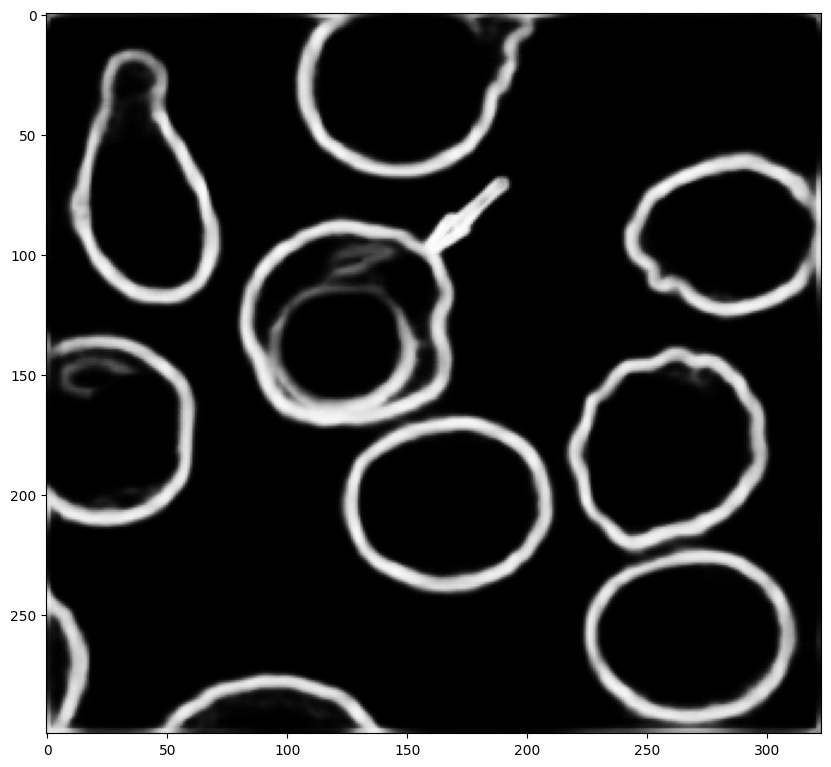

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(hedNetOutput, cmap='gray')
plt.show()

## Extract the objects (Red Blood Cells) using edge information

Using both X-Y Sobel edge output and apply simple threshold to keep only strong edge

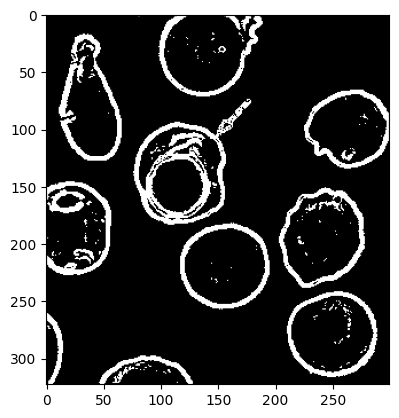

In [16]:
sobelXYOutput = sobelXOutput_64F + sobelYOutput_64F
sobelXYOutput = np.uint8(sobelXYOutput > 60)
plt.imshow(sobelXYOutput, cmap='gray')
plt.show()

Categorize each strong edge pixel into contours by using <a href="https://docs.opencv.org/4.5.1/d3/dc0/group__imgproc__shape.html#gae4156f04053c44f886e387cff0ef6e08">cv2.findContour</a>

In [17]:
rbcContours, _ = cv2.findContours(sobelXYOutput, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Colorize each contour by using <a href="https://docs.opencv.org/3.4.2/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc">cv2.drawContour</a>. You will see that there are some <b>noise</b> contours appear.

Total Red Blood Cell: 72


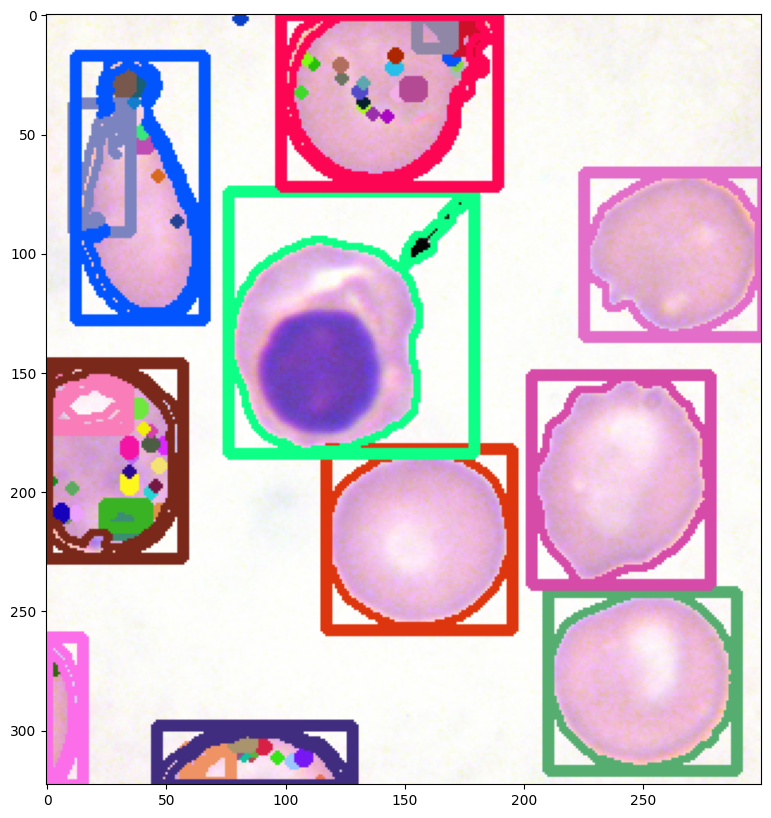

In [18]:
rbcContourImage = inputImage.copy()
for rcbContourIdx in range(len(rbcContours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    # Calculates the bounding rectangle of a contour
    x, y, w, h = cv2.boundingRect(rbcContours[rcbContourIdx])
    cv2.drawContours(rbcContourImage, rbcContours, rcbContourIdx, color, 2)
    cv2.rectangle(rbcContourImage,(x,y),(x+w,y+h),color,3)
rbcContourImage = cv2.cvtColor(rbcContourImage,cv2.COLOR_BGR2RGB)
print('Total Red Blood Cell:',len(rbcContours))
plt.figure(figsize=(10,10))
plt.imshow(rbcContourImage)
plt.show()

## Assignment 1 - Improved Simple RBC Detector
Is there anyway to improve the rcb detection quality? Why you do that? You can use the knowledge from previous and this lecture to answer this question! Implement your own modifiation in the following block and display the output for <b>both Lab3-rbc.jpg and Lab3-rbc2.jpg</b>.

Total Red Blood Cell: 8


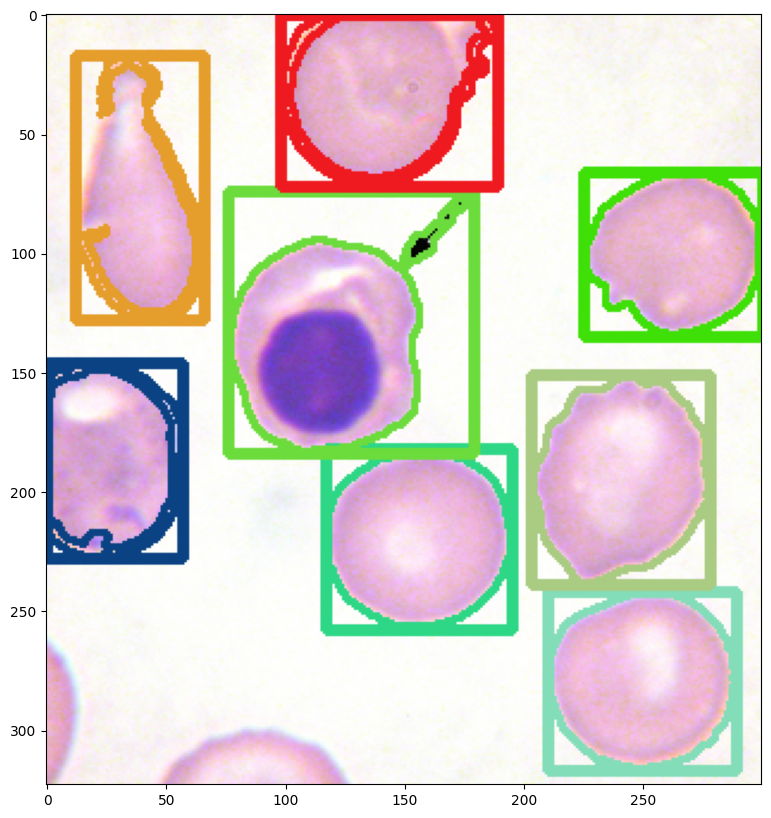

In [23]:
#### FILL HERE ####
rbcContourImage = inputImage.copy()
cou = 0
for rcbContourIdx in range(len(rbcContours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    # Calculates the bounding rectangle of a contour
    x, y, w, h = cv2.boundingRect(rbcContours[rcbContourIdx])
    if w <= 50 or h <= 50:
        continue
    cou += 1
    cv2.drawContours(rbcContourImage, rbcContours, rcbContourIdx, color, 2)
    cv2.rectangle(rbcContourImage,(x,y),(x+w,y+h),color,3)
rbcContourImage = cv2.cvtColor(rbcContourImage,cv2.COLOR_BGR2RGB)
print('Total Red Blood Cell:', cou)
plt.figure(figsize=(10,10))
plt.imshow(rbcContourImage)
plt.show()
####

## Assignment 2 - Card Detector
Assume that we got a requirement from Chula Office of Registrar to build an automate student id card face verification system (validating an identity based on the real face and face image on card). Your team's task is to implement an automatic algorithm to <b>extract</b> student faces from their id card and collect their card into image file. It should be note that the input images can be in <b>arbitrary viewpoint</b> so you must apply homography to correct perspective distortion. You should applied the algorithm on your student id card. <b>Don't forget to censor your sensitive information.</b>

<b>Guidance</b>
1. Apply your choice edge detector
2. Categorize each edge pixel into contours by using cv2.findContours
3. Pick the largest contour and find its hull using <a href="https://docs.opencv.org/3.4.2/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656">cv2.convexHull</a>
4. Approximate contour into 4 points polygon to find its corners using <a href="https://docs.opencv.org/3.4.2/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c">cv2.approxPolyDP</a>
5. Correct the perspective distortion by using cv2.getPerspectiveTransform / cv2.warpPerspective
6. Save the output warped id card image and face into file using cv2.imwrite 

<b>Hint</b>
- Too big image sometimes gives a poor edge detection result.
- This <a href="https://docs.opencv.org/3.4.2/dd/d49/tutorial_py_contour_features.html">link</a> helps a lot for 3-4
- The points order for cv2.getPerspectiveTransform must be consistent between source and destination.
- You can use Chula student id card face mask is given in <b>'assets/Lab3-FaceMask.bmp'</b>

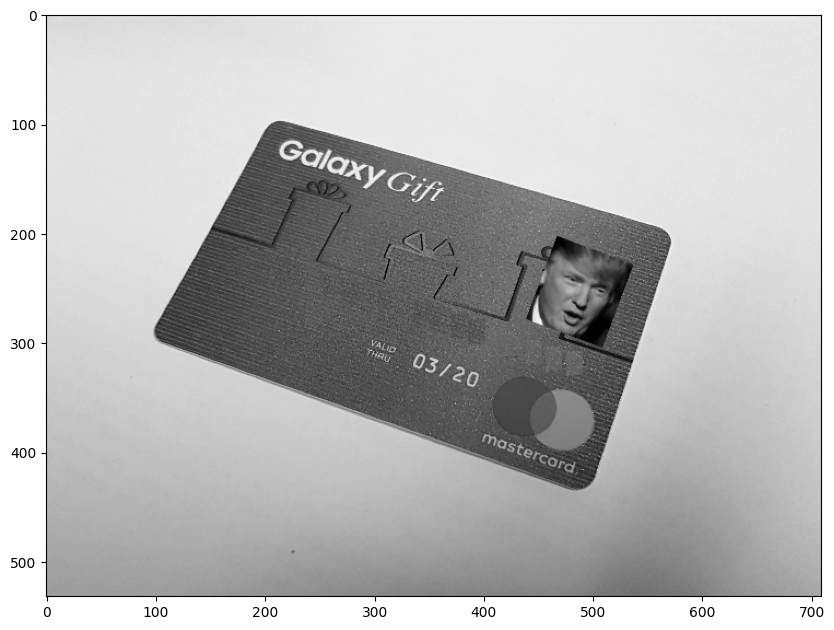

In [20]:
inputImageT = cv2.imread('assets/Lab3-TestCard2.jpg')
inputImageT = cv2.resize(inputImageT,None,fx=0.3,fy=0.3)
inputImageGray = cv2.cvtColor(inputImageT,cv2.COLOR_BGR2GRAY)
maskImage = cv2.imread('assets/Lab3-FaceMask.bmp')
plt.figure(figsize=(10,10))
plt.imshow(inputImageGray,cmap='gray')
plt.show()